In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ../..

/media/samuele/Disco/PycharmProjectsUbuntu/MARL-CER


In [2]:
import jax
import jax.numpy as jnp
from flax import nnx
from functools import partial
from jax_tqdm import scan_tqdm

from algorithms.utils import save_state, restore_state

import numpy as np

2025-02-25 18:17:16.913539: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740503836.925905   21169 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740503836.929470   21169 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
from ernestogym.envs_jax.single_agent.env import MicroGridEnv
from ernestogym.envs_jax.single_agent.env_trading_soc import MicroGridEnvSocAction

In [4]:
def my_env_creator(params, battery_type, env_type='normal'):
    if env_type == 'normal':
        env = MicroGridEnv(params, battery_type)
    elif env_type == 'soc_action':
        env = MicroGridEnvSocAction(params, battery_type)
    else:
        raise ValueError('Unknown env_type')
    return env, env.params

In [5]:
from ernestogym.envs_jax.single_agent.utils import parameter_generator

In [6]:
pack_options = "ernestogym/ernesto_jax/data/battery_new/pack.yaml"
ecm = "ernestogym/ernesto_jax/data/battery_new/models/electrical/thevenin_pack.yaml"
# ecm = "ernestogym/ernesto_jax/data/battery_new/models/electrical/thevenin_fading_pack.yaml"
r2c = "ernestogym/ernesto_jax/data/battery_new/models/thermal/r2c_thermal_pack.yaml"
# bolun = "ernestogym/ernesto_jax/data/battery_new/models/aging/bolun_pack.yaml"
bolun = "ernestogym/ernesto_jax/data/battery_new/models/aging/bolun_pack.yaml"
world = "ernestogym/envs_jax/single_agent/ijcnn_deg_train.yaml"
# world = "ernestogym/envs_jax/single_agent/world_fading.yaml"

# battery_type = 'fading'
# battery_type = 'degrading'
battery_type = 'degrading_dropflow'

params = parameter_generator(
    input_var='current',
    battery_options=pack_options,
    electrical_model=ecm,
    thermal_model=r2c,
    aging_model=bolun,
    world_options=world,
    use_reward_normalization=True

)

params

{'battery': {'sign_convention': 'passive',
  'params': {'nominal_voltage': 350.4,
   'nominal_capacity': 60.0,
   'nominal_dod': 0.8,
   'nominal_lifetime': 3000,
   'v_max': 398.4,
   'v_min': 288.0,
   'temp_ambient': 298.15,
   'nominal_cost': 3000.0},
  'bounds': {'voltage': {'low': 288.0, 'high': 398.4},
   'current': {'low': -180.0, 'high': 60.0},
   'power': {'low': -71712.0, 'high': 23904.0},
   'temperature': {'low': 273.15, 'high': 323.15},
   'temp_ambient': {'low': 273.15, 'high': 323.15},
   'soc': {'low': 0.2, 'high': 1.0},
   'soh': {'low': 0.6, 'high': 1.0}},
  'init': {'voltage': 310.8,
   'current': 0.0,
   'power': 0.0,
   'temperature': 293.15,
   'temp_ambient': 293.15,
   'soc': 0.2,
   'soh': 1.0}},
 'input_var': 'current',
 'models_config': [{'type': 'electrical',
   'class_name': 'TheveninModel',
   'use_fading': False,
   'components': {'r0': {'selected_type': 'lookup',
     'scalar': 10.0,
     'lookup': {'table': 'r0_pack.csv',
      'inputs': [{'var': 'temp

In [7]:
pack_options = "ernestogym/ernesto_jax/data/battery_new/pack.yaml"
ecm = "ernestogym/ernesto_jax/data/battery_new/models/electrical/thevenin_pack.yaml"
# ecm = "ernestogym/ernesto_jax/data/battery_new/models/electrical/thevenin_fading_pack.yaml"
r2c = "ernestogym/ernesto_jax/data/battery_new/models/thermal/r2c_thermal_pack.yaml"
# bolun = "ernestogym/ernesto_jax/data/battery_new/models/aging/bolun_pack.yaml"
bolun = "ernestogym/ernesto_jax/data/battery_new/models/aging/bolun_pack.yaml"
world = "ernestogym/envs_jax/single_agent/ijcnn_deg_test.yaml"
# world = "ernestogym/envs_jax/single_agent/world_fading.yaml"

params_testing = parameter_generator(
    input_var='current',
    battery_options=pack_options,
    electrical_model=ecm,
    thermal_model=r2c,
    aging_model=bolun,
    world_options=world,
    use_reward_normalization=True

)

params_testing['step']

3600

In [8]:
a = jnp.array([[[[[[[2]]]]]]])
a = jnp.clip(a, 0, 1)
a.flatten()[0]
b = jnp.array(3)
b.flatten()

Array([3], dtype=int32, weak_type=True)

In [9]:
from algorithms.recurrent_ppo import make_train, train        #, train_for, train_for_flax
from flax.core.frozen_dict import freeze, unfreeze

In [10]:
num_envs = 4

config = {
    "LR": 1e-3,
    "NUM_ENVS": num_envs,
    "NUM_STEPS": 8192, #2048 #10000,
    # "TOTAL_TIMESTEPS": 100000 * num_envs,
    "TOTAL_TIMESTEPS": 876000 * num_envs,
    "UPDATE_EPOCHS": 10,
    "NUM_MINIBATCHES": 128,
    "NORMALIZE_ENV": False,
    "GAMMA": 0.99,
    "GAE_LAMBDA": 0.95,
    "CLIP_EPS": 0.2,
    "ENT_COEF": 0.01,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "NET_ARCH": (32, 32, 16), #(16, 16, 16),
    "LSTM_NET_ARCH": (16, 8),
    "ACTIVATION": 'relu',
    "LSTM_ACTIVATION": 'tanh',
    "LOGISTIC_FUNCTION_TO_ACTOR": False,
    "ENV_NAME": None,
    "ANNEAL_LR": True,
    'DEBUG': False,
    "NORMALIZE_ADVANTAGES": True,
    "ENV_TYPE": 'normal',
    'NETWORK': 'recurrent_actor_critic'
}

env_type = config['ENV_TYPE']

rng = jax.random.PRNGKey(42)

env, env_params = my_env_creator(params, battery_type, env_type=env_type)
env, env_params, train_state = make_train(config, env, env_params)

env_testing, env_testing_params = my_env_creator(params_testing, battery_type, env_type=env_type)

val_rng = jax.random.PRNGKey(51)
val_num_iters = 8670*8

# out = train_jit(rng)

config = freeze(config)

In [11]:
network, optimizer = nnx.merge(train_state.graph_def, train_state.state)

In [12]:
network

RecurrentActorCritic(
  act_layers=[Linear(
    bias=Param(
      value=Array(shape=(32,), dtype=float32)
    ),
    bias_init=<function constant.<locals>.init at 0x7b6820068fe0>,
    dot_general=<function dot_general at 0x7b68bd55b6a0>,
    dtype=None,
    in_features=12,
    kernel=Param(
      value=Array(shape=(12, 32), dtype=float32)
    ),
    kernel_init=<function orthogonal.<locals>.init at 0x7b68200693a0>,
    out_features=32,
    param_dtype=<class 'jax.numpy.float32'>,
    precision=None,
    use_bias=True
  ), <jax._src.custom_derivatives.custom_jvp object at 0x7b68bcc7e330>, Linear(
    bias=Param(
      value=Array(shape=(32,), dtype=float32)
    ),
    bias_init=<function constant.<locals>.init at 0x7b682006b880>,
    dot_general=<function dot_general at 0x7b68bd55b6a0>,
    dtype=None,
    in_features=32,
    kernel=Param(
      value=Array(shape=(32, 32), dtype=float32)
    ),
    kernel_init=<function orthogonal.<locals>.init at 0x7b682006bec0>,
    out_features=32,
 

Running for 106 iterations:   0%|          | 0/106 [00:00<?, ?it/s]

curr_iter: 0
	r_tot: -1895.154541015625
	r_trad: -655.5324096679688
	r_deg: -0.6093084812164307
	r_clip: -1239.0128173828125
curr_iter: 10
	r_tot: -1128.158203125
	r_trad: -250.92074584960938
	r_deg: -112.39215850830078
	r_clip: -764.84521484375
curr_iter: 20
	r_tot: -490.54327392578125
	r_trad: 28.06155014038086
	r_deg: -154.41744995117188
	r_clip: -364.1873779296875
curr_iter: 30
	r_tot: -641.2888793945312
	r_trad: -23.49675750732422
	r_deg: -153.4093780517578
	r_clip: -464.3826904296875
curr_iter: 40
	r_tot: -375.0484924316406
	r_trad: 23.450754165649414
	r_deg: -169.00732421875
	r_clip: -229.49188232421875
curr_iter: 50
	r_tot: -412.3428039550781
	r_trad: 33.01796340942383
	r_deg: -168.04754638671875
	r_clip: -277.3132019042969
curr_iter: 60
	r_tot: -267.5396423339844
	r_trad: 69.22728729248047
	r_deg: -184.8770751953125
	r_clip: -151.889892578125
curr_iter: 70
	r_tot: -297.4298095703125
	r_trad: 70.25910949707031
	r_deg: -169.48431396484375
	r_clip: -198.2046356201172
curr_iter: 8

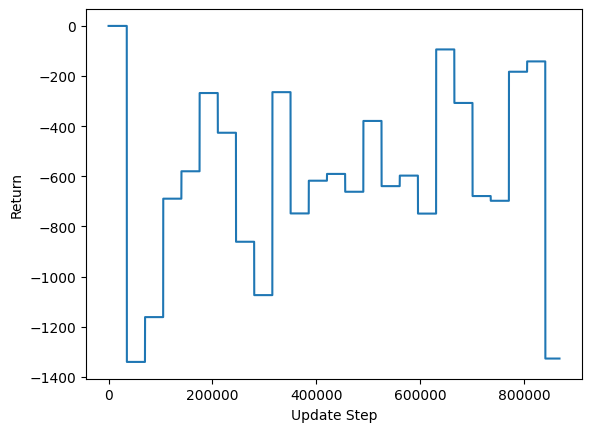

In [13]:
import time
import matplotlib.pyplot as plt
rng = jax.random.PRNGKey(42)
t0 = time.time()

# with jax.profiler.trace("/tmp/jax-trace", create_perfetto_link=True):
#     # Run the operations to be profiled
out = jax.block_until_ready(train(env, env_params, config, train_state, rng, validate=True, freq_val=10, val_env=env_testing, val_params=env_testing_params, val_rng=val_rng, val_num_iters=val_num_iters))

# out = train_for_flax(env, env_params, config, network, optimizer, rng)

train_state = out['runner_state'][0]
val_info = out.get('val_info')

print(f"time: {time.time() - t0:.2f} s")
plt.plot(out["metrics"]["returned_episode_returns"].mean(-1).reshape(-1))
plt.xlabel("Update Step")
plt.ylabel("Return")
plt.show()

In [14]:
network, optimizer = nnx.merge(train_state.graph_def, train_state.state)
network

RecurrentActorCritic(
  act_layers=[Linear(
    bias=Param(
      value=Array(shape=(32,), dtype=float32)
    ),
    bias_init=<function constant.<locals>.init at 0x7b6820068fe0>,
    dot_general=<function dot_general at 0x7b68bd55b6a0>,
    dtype=None,
    in_features=12,
    kernel=Param(
      value=Array(shape=(12, 32), dtype=float32)
    ),
    kernel_init=<function orthogonal.<locals>.init at 0x7b68200693a0>,
    out_features=32,
    param_dtype=<class 'jax.numpy.float32'>,
    precision=None,
    use_bias=True
  ), <jax._src.custom_derivatives.custom_jvp object at 0x7b68bcc7e330>, Linear(
    bias=Param(
      value=Array(shape=(32,), dtype=float32)
    ),
    bias_init=<function constant.<locals>.init at 0x7b682006b880>,
    dot_general=<function dot_general at 0x7b68bd55b6a0>,
    dtype=None,
    in_features=32,
    kernel=Param(
      value=Array(shape=(32, 32), dtype=float32)
    ),
    kernel_init=<function orthogonal.<locals>.init at 0x7b682006bec0>,
    out_features=32,
 

## State saving

In [16]:
from algorithms.utils import save_state
save_state(network, config, params, val_info, env_type=env_type, additional_info='')

In [17]:
out

{'metrics': {'action': Array([[[[ 1.1667    ],
           [-0.38246194],
           [-0.8464092 ],
           [-0.5786371 ]],
  
          [[-1.2350703 ],
           [ 0.44452134],
           [-0.23722094],
           [ 0.25269896]],
  
          [[-0.19366331],
           [-0.05670249],
           [-1.2808448 ],
           [-0.24673736]],
  
          ...,
  
          [[-0.12864694],
           [ 0.9067258 ],
           [ 0.5875475 ],
           [-0.06958868]],
  
          [[ 0.71966743],
           [ 0.5895232 ],
           [-0.8175718 ],
           [ 1.842556  ]],
  
          [[ 0.52324957],
           [ 1.5427955 ],
           [ 0.4241266 ],
           [ 0.67844665]]],
  
  
         [[[ 0.99572134],
           [ 1.5612388 ],
           [-0.6130604 ],
           [-2.498987  ]],
  
          [[-1.3035035 ],
           [-1.7527558 ],
           [-1.7661105 ],
           [ 1.0498921 ]],
  
          [[ 0.935541  ],
           [-0.01047059],
           [ 0.91039354],
           [ 0.

In [18]:
r_trad = out['metrics']['weig_reward']['r_trad'].mean(-1).reshape(-1)
r_trad_cum = np.cumsum(r_trad)
r_trad.shape

(868352,)

In [19]:
acts = out['metrics']['action'].flatten()
acts.min(), acts.max(), acts.mean()

(Array(-4.499702, dtype=float32),
 Array(4.23774, dtype=float32),
 Array(-0.03196479, dtype=float32))

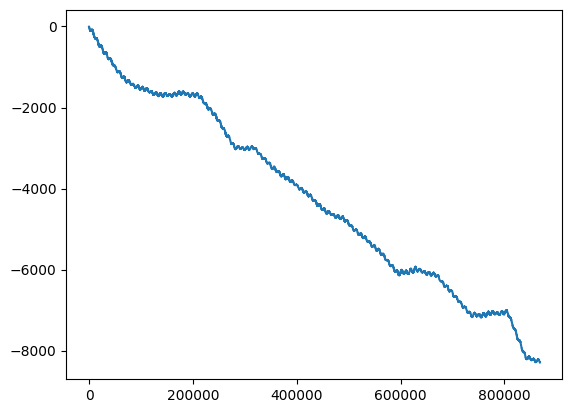

In [20]:
plt.plot(r_trad_cum)

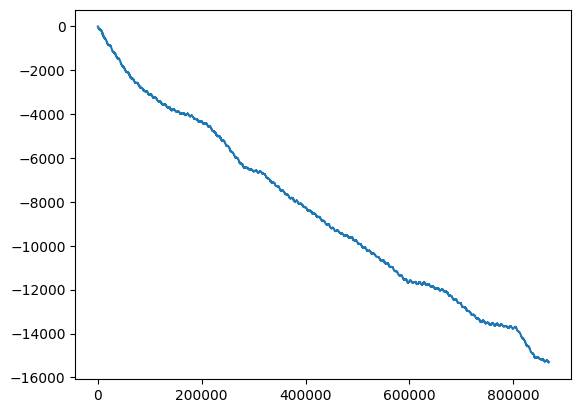

In [21]:
r_tot_cum = np.cumsum(out['metrics']['r_tot'].mean(-1).reshape(-1))
plt.plot(r_tot_cum)

# Testing

In [22]:
pack_options = "ernestogym/ernesto_jax/data/battery_new/pack.yaml"
ecm = "ernestogym/ernesto_jax/data/battery_new/models/electrical/thevenin_pack.yaml"
# ecm = "ernestogym/ernesto_jax/data/battery_new/models/electrical/thevenin_fading_pack.yaml"
r2c = "ernestogym/ernesto_jax/data/battery_new/models/thermal/r2c_thermal_pack.yaml"
# bolun = "ernestogym/ernesto_jax/data/battery_new/models/aging/bolun_pack.yaml"
bolun = "ernestogym/ernesto_jax/data/battery_new/models/aging/bolun_pack.yaml"
world = "ernestogym/envs_jax/single_agent/ijcnn_deg_test.yaml"
# world = "ernestogym/envs_jax/single_agent/world_fading.yaml"

# battery_type = 'fading'
# battery_type = 'degrading'
battery_type = 'degrading_dropflow'

params = parameter_generator(
    input_var='current',
    battery_options=pack_options,
    electrical_model=ecm,
    thermal_model=r2c,
    aging_model=bolun,
    world_options=world,
    use_reward_normalization=True

)

params['step']

3600

In [23]:
@partial(jax.jit, static_argnums=(0, 2, 3))
def test(env: MicroGridEnv, env_params, network, num_iter, rng):

    rng, _rng = jax.random.split(rng)

    obsv, env_state = env.reset(_rng, env_params)

    act_state, cri_state = network.get_initial_lstm_state()

    @scan_tqdm(num_iter, print_rate=num_iter // 100)
    def _env_step(runner_state, unused):
        obsv, env_state, act_state, rng = runner_state

        pi, _, act_state, _ = network(obsv, act_state, cri_state)

        #deterministic action
        action = pi.mode()

        rng, _rng = jax.random.split(rng)
        obsv, env_state, reward, done, info = env.step(_rng, env_state, action, env_params)

        runner_state = (obsv, env_state, act_state, rng)
        return runner_state, (info, action)

    runner_state = (obsv, env_state, act_state, rng)

    runner_state, info = jax.lax.scan(_env_step, runner_state, jnp.arange(num_iter))

    return info

In [24]:
env, env_params = my_env_creator(params, battery_type, env_type=env_type)
env_params = env.eval(env_params)

In [25]:
num_iter = 8760 #* 8
info, actions = test(env, env_params, network, num_iter, jax.random.PRNGKey(51))


Running for 8,760 iterations:   0%|          | 0/8760 [00:00<?, ?it/s]

In [26]:
jax.tree.map(lambda val: val.shape, info)

{'buy_price': (8760,),
 'demand': (8760,),
 'generation': (8760,),
 'i_to_apply': (8760,),
 'norm_reward': {'r_clipping': (8760,),
  'r_deg': (8760,),
  'r_op': (8760,),
  'r_trad': (8760,)},
 'p': (8760,),
 'pure_reward': {'r_clipping': (8760,),
  'r_deg': (8760,),
  'r_op': (8760,),
  'r_trad': (8760,)},
 'r_tot': (8760,),
 'sell_price': (8760,),
 'soc': (8760,),
 'soh': (8760,),
 'weig_reward': {'r_clipping': (8760,),
  'r_deg': (8760,),
  'r_op': (8760,),
  'r_trad': (8760,)}}

In [27]:
actions.max(), actions.min(), actions.mean()

(Array(1.2764502, dtype=float32),
 Array(-1.4250182, dtype=float32),
 Array(-0.03189993, dtype=float32))

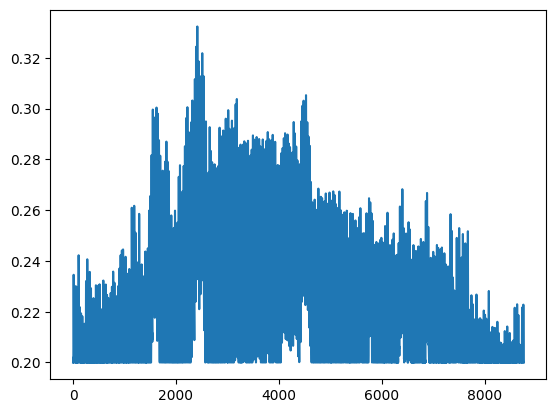

In [28]:
plt.plot(info['soc'])

In [29]:
reward_type = 'weig_reward'

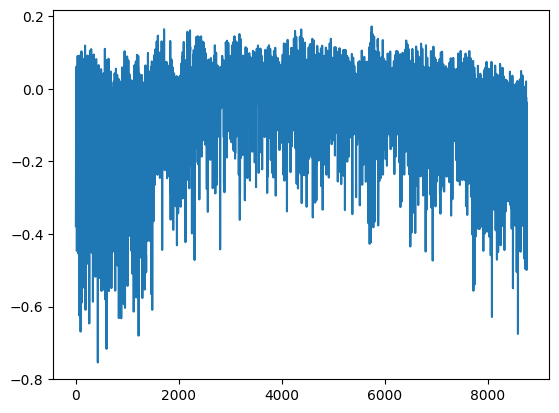

In [30]:
plt.plot(info[reward_type]['r_trad'])

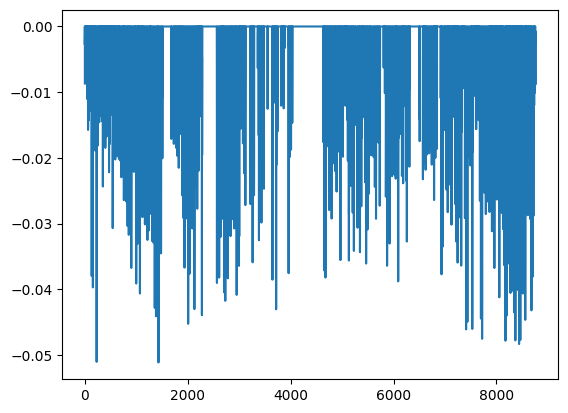

In [31]:
plt.plot(info[reward_type]['r_clipping'])

In [32]:
info['pure_reward']['r_clipping'].mean(), info['weig_reward']['r_clipping'].mean()

(Array(-11.055914, dtype=float32), Array(-0.00325653, dtype=float32))

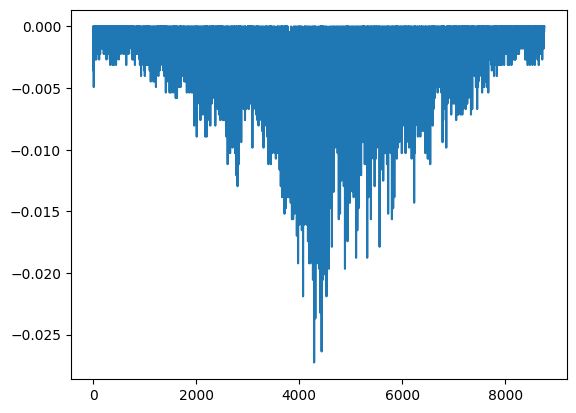

In [33]:
plt.plot(info[reward_type]['r_deg'])

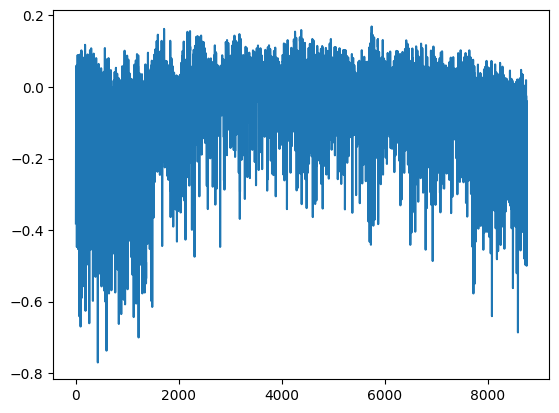

In [34]:
plt.plot(info['r_tot'])

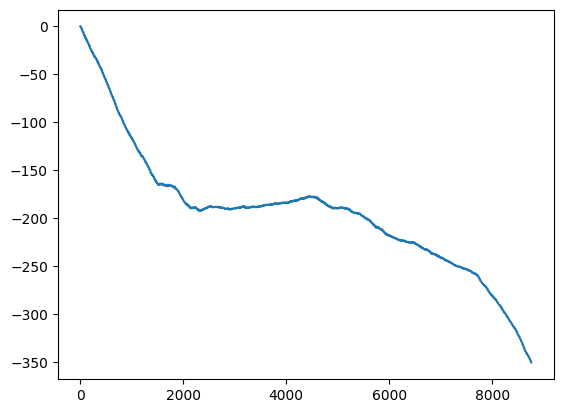

In [35]:
plt.plot(np.cumsum(info[reward_type]['r_trad']))

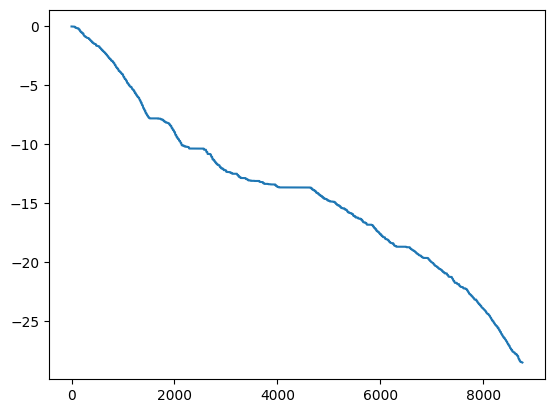

In [36]:
plt.plot(np.cumsum(info[reward_type]['r_clipping']))

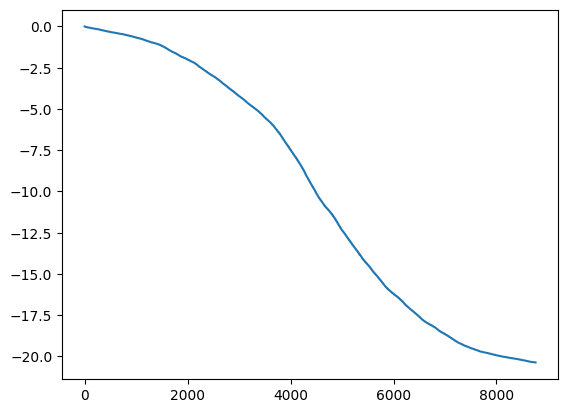

In [37]:
plt.plot(np.cumsum(info[reward_type]['r_deg']))

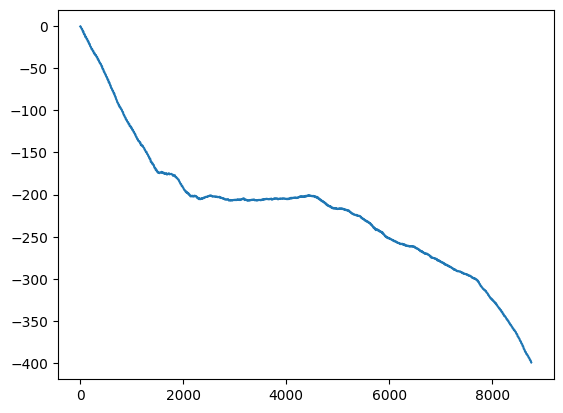

In [38]:
plt.plot(np.cumsum(info['r_tot']))

In [39]:
print(info['soc'])

[0.2        0.20110562 0.2017464  ... 0.2        0.2        0.2       ]


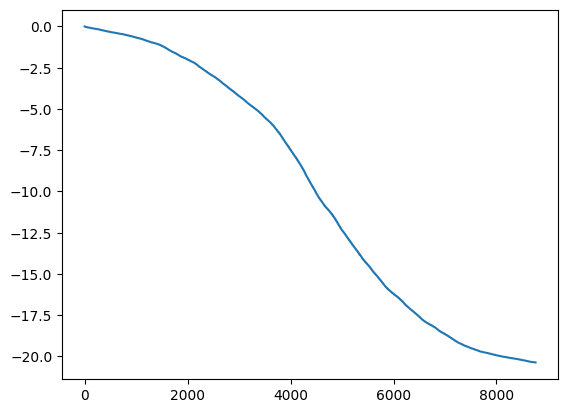

In [40]:
plt.plot(np.cumsum(info[reward_type]['r_deg']))

In [41]:
print(info['soc'])

[0.2        0.20110562 0.2017464  ... 0.2        0.2        0.2       ]
